## Problem 1

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import t, norm
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
dat = pd.read_csv('problem1.csv')

In [10]:
def var_normal(returns, significance_level=0.05, num_samples=10000):
    # Calculate the mean and standard deviation of the returns
    mean_return = returns.mean()
    std_return = returns.std()
    
    # Generate random samples from a normal distribution based on the historical mean and std deviation
    simulated_returns = np.random.normal(mean_return, std_return, num_samples)
    
    # Sort the simulated returns in ascending order
    simulated_returns.sort()
    
    # Compute the Value-at-Risk (VaR) at the given significance level
    VaR = -simulated_returns[int(significance_level * len(simulated_returns))]
    
    return VaR, simulated_returns

def var_t(returns, significance_level=0.05, num_samples=10000):
    # Fit the returns to a t-distribution using MLE
    df, loc, scale = t.fit(returns, method="MLE")
    
    # Generate random samples from the fitted t-distribution
    simulated_returns = t.rvs(df, loc, scale, size=num_samples)
    
    # Sort the simulated returns in ascending order
    simulated_returns.sort()
    
    # Compute the Value-at-Risk (VaR) at the given significance level
    VaR = -simulated_returns[int(significance_level * len(simulated_returns))]
    
    return VaR, simulated_returns

def calculate_es(var, sim_data):
    return -np.mean(sim_data[sim_data <= -var])


In [19]:
var_normal_value, simulated_data_normal = var_normal(dat['x'])
es_normal = calculate_es(var_normal_value, simulated_data_normal)

var_t_value, simulated_data_t = var_t(dat['x'])
es_t = calculate_es(var_t_value, simulated_data_t)

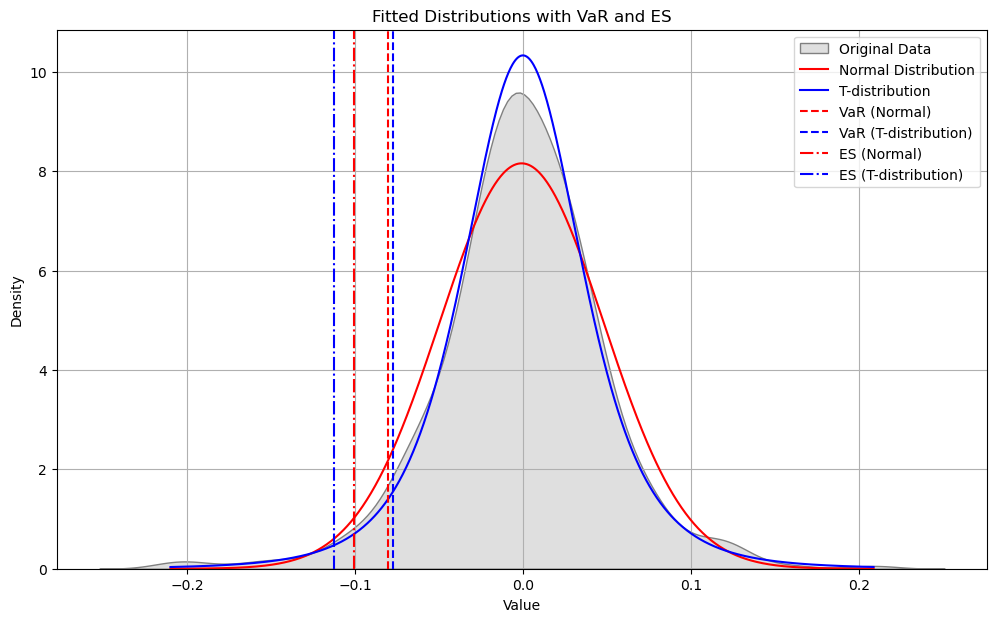

,Distribution,VaR,ES
0,Normal,0.080394,0.100493
1,t-distribution,0.077107,0.112403


In [22]:
table_data = {
    'Distribution': ['Normal', 't-distribution'],
    'VaR': [var_normal_value, var_t_value],
    'ES': [es_normal, es_t]
}
table_df = pd.DataFrame(table_data)

# Plotting the distribution PDFs, VaR, and ES values
x_values = np.linspace(min(dat['x']), max(dat['x']), 1000)
pdf_normal = norm.pdf(x_values, dat['x'].mean(), dat['x'].std())
pdf_t = t.pdf(x_values, *t.fit(dat['x'], method="MLE"))

# Plotting
plt.figure(figsize=(12, 7))
sns.kdeplot(dat['x'], fill=True, label='Original Data', color='grey')
plt.plot(x_values, pdf_normal, 'r-', label='Normal Distribution')
plt.plot(x_values, pdf_t, 'b-', label='T-distribution')
plt.axvline(-var_normal_value, color='r', linestyle='--', label='VaR (Normal)')
plt.axvline(-var_t_value, color='b', linestyle='--', label='VaR (T-distribution)')
plt.axvline(-es_normal, color='r', linestyle='-.', label='ES (Normal)')
plt.axvline(-es_t, color='b', linestyle='-.', label='ES (T-distribution)')
plt.title('Fitted Distributions with VaR and ES')
plt.legend()
plt.grid(True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

table_df